In [1]:
# Writes a memo for CBS Reports on national sheriff stats.

In [2]:
import pandas as pd
from matplotlib import pyplot as plt


In [3]:
plt.style.use('seaborn-v0_8-white')
pd.set_option('display.max_columns', 100)

In [4]:
# read incidents 
incidents = (
    pd.read_excel(
        "../data/MPVDatasetDownload.xlsx",
        parse_dates = ["Date of Incident (month/day/year)"],
        sheet_name=0,
    )
    .rename(
        columns = { "ORI Agency Identifier (if available)": "ori" }
    )
    .rename_axis("incident_uid")
    .reset_index()
)

incidents.head(3)

,incident_uid,Victim's name,Victim's age,Victim's gender,Victim's race,URL of image of victim,Date of Incident (month/day/year),Street Address of Incident,City,State,Zipcode,County,Agency responsible for death,ori,Cause of death,Media description of the circumstances surrounding the death,Official disposition of death (justified or other),Criminal Charges?,Link to news article or photo of official document,Symptoms of mental illness?,Armed/Unarmed Status,Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database),Alleged Threat Level (Source: WaPo and Review of Cases Not Included in WaPo Database),Threat Level Description,Fleeing (Source: WaPo and Review of Cases Not Included in WaPo Database),Body Camera (Source: WaPo),WaPo ID (If included in WaPo database),Off-Duty Killing?,Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx ),MPV ID,Fatal Encounters ID,Encounter Type,Initial Reported Reason for Encounter,Names of Officers Involved,Race of Officers Involved,Known Past Shootings of Officer(s),Call for Service?,Census Tract Code,HUD UPSAI Geography,NCHS Urban-Rural Classification Scheme Codes (https://www.cdc.gov/nchs/data_access/urban_rural.htm),Median household income ACS Census Tract,Latitude,Longitude,Total Population of Census Tract 2019 ACS 5-Year Estimates,White Non-Hispanic Percent of the Population ACS,Black Non-Hispanic Percent of the Population ACS,Native American Percent of the Population ACS,Asian Percent of the Population ACS,Pacific Islander Percent of the Population ACS,Other/Two or More Race Percent of the Population ACS,Hispanic Percent of the Population ACS,Congressional District,Congressional Representative Full Name (https://ballotpedia.org/United_States_House_of_Representatives),Unnamed: 52,Congressional Representative Party (https://ballotpedia.org/United_States_House_of_Representatives),Officer Prosecuted by (Chief Prosecutor),Prosecutor Race,Prosecutor Gender,Chief Prosecutor Political Party,Chief Prosecutor Term,Officer Prosecuted by (Prosecutor in Court),Special Prosecutor?,Independent Investigation?,Prosecutor Source Link,Killed by Police 2013-24
0,0,Dario Agudelo,29,Male,Hispanic,NaN,2024-02-15,62 E Michigan Ave,Battle Creek,MI,NaN,Calhoun,Battle Creek Police Department,MI1323700,Gunshot,"Officers were called to Café Rica, 62 E. Mich...",NaN,NaN,https://www.battlecreekenquirer.com/story/news...,No,Allegedly Armed,gun,attack,used weapon,Not Fleeing,NaN,NaN,NaN,NaN,12724,NaN,None/Unknown,suspicious person,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,Curtis Wallace,36,Male,Unknown race,NaN,2024-02-15,Adams Ave and Newtown Ave,Philadelphia,PA,NaN,Philadelphia,Philadelphia Police Department,PAPEP0000,Gunshot,The ordeal began shortly after 7 p.m. at the i...,NaN,NaN,https://www.nbcphiladelphia.com/news/local/phi...,No,Vehicle,vehicle,attack,used weapon,Car,NaN,NaN,NaN,NaN,12723,NaN,Traffic Stop,traffic stop,NaN,NaN,NaN,Unavailable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2,William Lowery,46,Male,Unknown race,NaN,2024-02-14,5th St and Val Vista St,Sheridan,WY,NaN,Sheridan,"Gillette Police Department, Sheridan Police De...",WY0030100;WY0170100;WY0130000,Gunshot,A man allegedly shot a police officer serving ...,NaN,NaN,https://www.seattlepi.com/news/article/a-wyomi...,No,Allegedly Armed,gun,attack,used weapon,Foot,No,10150.0,NaN,NaN,12722,NaN,Other Non-Violent Offense,trespassing,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


### Staffing

In [5]:
leoka = (
    pd.read_csv("../outputs/agency_staff_all_years.csv")
)

leoka.head(3)

,year,state_abb,agency_type,agencies,officers,total_staff
0,1960,AK,local police department,6,110.0,138.0
1,1960,AK,state law enforcement agency,1,0.0,0.0
2,1960,AL,local police department,106,1815.0,2023.0


In [6]:
leoka_agencies = (
    leoka
    .groupby(
        ["year", "agency_type"]
    )
    .sum()
    .reset_index()
    .pivot(
        index = "year",
        columns = "agency_type",
        values = "agencies"
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

leoka_agencies.head(3)

,year,constable/marshal,federal,local police department,sheriffs office,special jurisdiction,state law enforcement agency
0,1960,4.0,NaN,5334.0,3022.0,13.0,15.0
1,1961,4.0,NaN,5343.0,3045.0,13.0,15.0
2,1962,4.0,NaN,5549.0,3046.0,14.0,16.0


In [7]:
# load staffing and calculate the percent sheriff
leoka_staff = (
    leoka
    # .loc[ lambda x: x["agency_type"].isin(["local police department", "sheriffs office"]) ]
    .pivot(
        index = ["year", "state_abb"],
        columns = "agency_type",
        values = "total_staff"
    )
    .reset_index()
    .rename_axis(None, axis=1)
    .fillna(0)
    .drop(columns = ["state_abb"])
    .groupby("year")
    .sum()
    .reset_index()
    .assign(
        other_staff = lambda x: x["constable/marshal"] + x["state law enforcement agency"] + x["federal"] + x["special jurisdiction"],
        total_staff = lambda x: x["local police department"] + x["sheriffs office"] + x["other_staff"]
    )
    .assign(
        percent_sheriff = lambda x: x["sheriffs office"] / x["total_staff"] * 100,
        percent_police = lambda x: x["local police department"] / x["total_staff"] * 100
    )

)

leoka_staff.head()

,year,constable/marshal,federal,local police department,sheriffs office,special jurisdiction,state law enforcement agency,other_staff,total_staff,percent_sheriff,percent_police
0,1960,27.0,0.0,195461.0,122.0,6.0,1310.0,1343.0,196926.0,0.061952,99.256066
1,1961,46.0,0.0,180363.0,16658.0,151.0,4809.0,5006.0,202027.0,8.245433,89.276681
2,1962,34.0,0.0,202701.0,19213.0,6.0,1684.0,1724.0,223638.0,8.591116,90.637995
3,1963,30.0,31.0,196708.0,17409.0,232.0,0.0,293.0,214410.0,8.119491,91.743855
4,1964,31.0,0.0,197674.0,17754.0,16.0,105.0,152.0,215580.0,8.235458,91.694035


In [8]:
start_sheriff_staff = leoka_staff.query("year == 2013")["sheriffs office"].values[0]
end_sheriff_staff = leoka_staff.query("year == 2022")["sheriffs office"].values[0]
start_police_staff = leoka_staff.query("year == 2013")["local police department"].values[0]
end_police_staff = leoka_staff.query("year == 2022")["local police department"].values[0]

end_sheriff_growth = (end_sheriff_staff - start_sheriff_staff) / start_sheriff_staff * 100
end_police_growth = (end_police_staff - start_police_staff) / start_police_staff * 100


print(f"""
By proportion of staff, the number of staff in sheriff's offices has grown from {start_sheriff_staff}
in 2013 to {end_sheriff_staff} in 2022, an increase of {end_sheriff_growth:.1f}%.
Meanwhile, the number of staff in local police departments has actually shrunk by {end_police_growth:.1f}%
from 2013 to 2022.
""")




By proportion of staff, the number of staff in sheriff's offices has grown from 308110.0
in 2013 to 310839.0 in 2022, an increase of 0.9%.
Meanwhile, the number of staff in local police departments has actually shrunk by -4.8%
from 2013 to 2022.



In [9]:
incidents_flagged = (
    pd
    .read_csv(
        "../outputs/incidents_flagged.csv",
        parse_dates = ["Date of Incident (month/day/year)"],
    )
)

/tmp/ipykernel_8984/3987420465.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  pd


## Is the share of sheriffs incidents increasing?

In [10]:
# shorten for easier merging
incidents_short = (
    incidents_flagged
    .assign(
        year = lambda f: f["Date of Incident (month/day/year)"].dt.year,
    )
    [["incident_uid", "State", "year", "sheriff", "police", "others"]]
)

incidents_short.head()

,incident_uid,State,year,sheriff,police,others
0,0,MI,2024,False,True,False
1,1,PA,2024,False,True,False
2,2,WY,2024,True,True,False
3,3,IL,2024,False,True,False
4,4,VA,2024,False,True,False


In [11]:
incidents_short.groupby("year")[["sheriff", "police", "others"]].sum()

,sheriff,police,others
year,,,
2013,276,773,48
2014,280,735,49
2015,293,794,48
2016,303,728,58
2017,332,757,42
2018,329,786,67
2019,325,744,70
2020,379,758,82
2021,357,803,63


In [12]:
# confirm that in some incidents, both sheriff and police are flagged
incidents.query( "incident_uid == 2" )["Agency responsible for death"].values

array(["Gillette Police Department, Sheridan Police Department, Natrona County Sheriff's Office"],
      dtype=object)

In [13]:
# calculate proportion of sheriff incidents by year
sheriff_incidents = (
    incidents_short
    .loc[ lambda x: x["year"] < 2024 ]
    .groupby(["year"])
    .agg(
        incidents = ("incident_uid", "count"),
        sheriff_involved = ("sheriff", "sum"),
        police_involved = ("police", "sum"),
        others_involved = ("others", "sum"),
    )
    .assign(
        sheriff_involved_pct = lambda f: round(f["sheriff_involved"] / f["incidents"] * 100, 1),
        # includes state and federal police
        police_involved_pct = lambda f: round(f["police_involved"] / f["incidents"] * 100, 1),
        others_involved_pct = lambda f: round(f["others_involved"] / f["incidents"] * 100, 1),
    )
    .reset_index()
    .sort_values("year", ascending=True)
)

sheriff_incidents

,year,incidents,sheriff_involved,police_involved,others_involved,sheriff_involved_pct,police_involved_pct,others_involved_pct
0,2013,1077,276,773,48,25.6,71.8,4.5
1,2014,1039,280,735,49,26.9,70.7,4.7
2,2015,1100,293,794,48,26.6,72.2,4.4
3,2016,1065,303,728,58,28.5,68.4,5.4
4,2017,1089,332,757,42,30.5,69.5,3.9
5,2018,1139,329,786,67,28.9,69.0,5.9
6,2019,1098,325,744,70,29.6,67.8,6.4
7,2020,1160,379,758,82,32.7,65.3,7.1
8,2021,1148,357,803,63,31.1,69.9,5.5
9,2022,1202,423,798,61,35.2,66.4,5.1


In [14]:
# load all the descriptive stats into context
start_year = incidents_short["year"].min()
end_year = 2023
police_total_kill_23 = sheriff_incidents.query("year == 2023")["police_involved"].values[0]
sheriff_total_kill_23 = sheriff_incidents.query("year == 2023")["sheriff_involved"].values[0]
total_killings = sheriff_incidents["incidents"].sum()
yearly_killings = total_killings / (end_year - start_year )
total_sheriff_killings = sheriff_incidents["sheriff_involved"].sum()
total_police_killings = sheriff_incidents["police_involved"].sum()

total_sheriff_killing_percent = total_sheriff_killings / total_killings * 100
total_police_killing_percent = total_police_killings / total_killings * 100
sheriff_pct_22 = sheriff_incidents.query("year == 2022")["sheriff_involved_pct"].values[0]

# context["start_sheriff_killings"] = sheriff_incidents.loc[ lambda x: x["year"] == context["start_year"] ]["sheriff_involved_pct"].values[0]
# context["end_sheriff_killings"] = sheriff_incidents.loc[ lambda x: x["year"] == context["end_year"] ]["sheriff_involved_pct"].values[0]

start_sheriff_percent_killing = sheriff_incidents.loc[ lambda x: x["year"] == start_year ]["sheriff_involved_pct"].values[0]
end_sheriff_percent_killing = sheriff_incidents.loc[ lambda x: x["year"] == end_year ]["sheriff_involved_pct"].values[0]
start_police_percent_killing = sheriff_incidents.loc[ lambda x: x["year"] == start_year ]["police_involved_pct"].values[0]
end_police_percent_killing = sheriff_incidents.loc[ lambda x: x["year"] == end_year ]["police_involved_pct"].values[0]


print(
f"""
The percentage of killings by sheriff's offices has grown from {start_sheriff_percent_killing}% in {start_year} to {end_sheriff_percent_killing}% in {end_year}.
Meanwhile, the percentage of killings by police has shrunk from {start_police_percent_killing}% in {start_year} to {end_police_percent_killing}% in {end_year}.
"""
)


The percentage of killings by sheriff's offices has grown from 25.6% in 2013 to 31.4% in 2023.
Meanwhile, the percentage of killings by police has shrunk from 71.8% in 2013 to 67.9% in 2023.



# Viz

In [15]:
# calculate proportion of sheriff incidents by year
sheriff_incidents = (
    incidents_short
    .loc[ lambda x: x["year"] < 2024 ]
    .groupby(["year"])
    .agg(
        incidents = ("incident_uid", "count"),
        sheriff_involved = ("sheriff", "sum"),
        police_involved = ("police", "sum"),
        others_involved = ("others", "sum"),
    )
    .assign(
        sheriff_involved_pct = lambda f: round(f["sheriff_involved"] / f["incidents"] * 100, 1),
        # includes state and federal police
        police_involved_pct = lambda f: round(f["police_involved"] / f["incidents"] * 100, 1),
        others_involved_pct = lambda f: round(f["others_involved"] / f["incidents"] * 100, 1),
    )
    .reset_index()
    .sort_values("year", ascending=True)
)

sheriff_incidents.head()

,year,incidents,sheriff_involved,police_involved,others_involved,sheriff_involved_pct,police_involved_pct,others_involved_pct
0,2013,1077,276,773,48,25.6,71.8,4.5
1,2014,1039,280,735,49,26.9,70.7,4.7
2,2015,1100,293,794,48,26.6,72.2,4.4
3,2016,1065,303,728,58,28.5,68.4,5.4
4,2017,1089,332,757,42,30.5,69.5,3.9


In [16]:
# normalize for plotting stacked bars
sheriff_normalized = (
    sheriff_incidents
    .set_index("year")
    [["police_involved", "sheriff_involved", "others_involved"]]
    .pipe(
        # make everything a percent of the total
        lambda f: f.div(f.sum(axis=1), axis=0) * 100
    )
    .sort_index()
)

sheriff_normalized.tail()

,police_involved,sheriff_involved,others_involved
year,,,
2019,65.320457,28.533802,6.145742
2020,62.182116,31.091058,6.726825
2021,65.658217,29.190515,5.151267
2022,62.246490,32.995320,4.758190
2023,65.254237,30.123267,4.622496


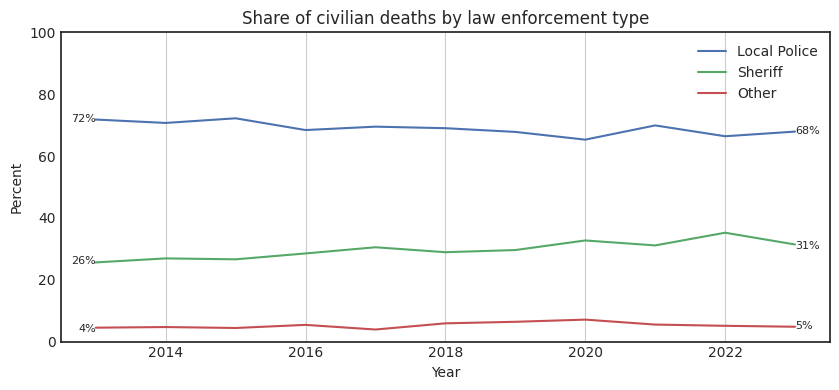

In [17]:
# plot the share of incidents by type for national and target states
sheriff_share_incidents = (
        sheriff_incidents
        .set_index("year")
        [["police_involved_pct", "sheriff_involved_pct", "others_involved_pct"]]
    )

# plot national
ax = (
    sheriff_share_incidents
    .plot(
        kind = "line",
        figsize = (8.5, 4),
        ylim = (0, 100),
        color = ["#4C72B0", "#55A868", "#C44E52"],
    )
)

# legend labels
ax.legend(["Local Police", "Sheriff", "Other"])

# Loop through each column to place text annotations
for col in sheriff_share_incidents.columns:
    # Beginning label
    start_value = sheriff_share_incidents[col].loc[2013].round(0)
    ax.text(2013, start_value, f'{start_value:.0f}%', va='center', ha='right', fontsize=8)

    # End label
    end_value = sheriff_share_incidents[col].loc[2023].round(0)
    ax.text(2023, end_value, f'{end_value:.0f}%', va='center', ha='left', fontsize=8)
ax.grid(axis='x')
ax.set_title("Share of civilian deaths by law enforcement type")
ax.set_ylabel("Percent")
ax.set_xlabel("Year")
fig = ax.get_figure()
fig.tight_layout()
# save as png
fig.savefig("../outputs/national_sheriff_vs_police.png")
plt.show()




---
---
---